# 主题建模与文档聚类

常用于文本数据的一种特殊技术是**主题建模**（topic modeling)，这是描述将每个文档分配给一个或多个主题的任务(通常是无监督的) 的概括性术语。这方面一个很好的例子是新闻数据，它们可以被分为“政治”“体育”“金融”等主题。如果为每个文档分配一个主题，那么这是一个文档聚类任务。我们学到的每个成分对应于一个主题，文档表示中的成分系数告诉我们这个文档与该主题的相关性强弱。通常来说，人们在谈论主题建模时，他们指的是一种叫作**隐含狄利克雷分布**(Latent Dirichlet Allocation，LDA)的特定分解方法。

## 隐含狄利克雷分布

从直观上来看，LDA模型试图找出频繁共同出现的单词群组 (即主题)。LDA还要求，每个文档可以被理解为主题子集的“混合”。重要的是要理解，机器学习模型所谓的“主题”可能不是我们通常在日常对话中所说的主题，而是更类似于PCA或NMF所提取的成分，它可能具有语义，也可能没有。即使LDA“主题”具有语义，它可能也不是我们通常所说的主题。回到新闻文章的例子，我们可能有许多关于体育、政治和金融的文章，由两位作者所写。在一篇政治文章中，我们预计可能会看到“州长”“投票”“党派”等词语，而在一篇体育文章中，我们预计可能会看到类似“队伍”“得分”和“赛季”之类的词语。这两组词语可能会同时出现，而例如“队伍”和“州长”就不大可能同时出现。但是，这并不是我们预计可能同时出现的唯一的单词群组这两位记者可能偏爱不同的短语或者选择不同的单词。可能其中一人喜欢使用“划界”(demarcate)这个词，而另一人喜欢使用“两极分化”(polarize) 这个词。其他“主题”可能是“记者A 常用的词语”和“记者 B 常用的词语”，虽然这并不是通常意义上的主题。

我们将LDA 应用于电影评论数据集，来看一下它在实践中的效果。对于无监督的文本文档模型，通常最好删除非常常见的单词，否则它们可能会支配分析过程。我们将删除至少在15%的文档中出现过的单词，并在删除前 15%之后，将词袋模型限定为最常见的 10 000个单词:

In [1]:
from sklearn.datasets import load_files
import numpy as np
reviews_train = load_files("E:/clone/machine-learning/data/aclImdb/train/")
# load_files返回一个Bunch对象，其中包含训练文本和训练标签

data_array = np.array(reviews_train.data)
target_array = np.array(reviews_train.target)

# Filter out documents where the target is not equal to 2
labeled_indices = np.where(target_array != 2)[0]
text_train, y_train = data_array[labeled_indices], target_array[labeled_indices]
text_train = [doc.replace(b'<br />',b' ') for doc in text_train]

reviews_test = load_files("E:/clone/machine-learning/data/aclImdb/test/")
data_array = np.array(reviews_test.data)
target_array = np.array(reviews_test.target)
text_test, y_test = data_array, target_array
text_test = [doc.replace(b'<br />',b' ') for doc in text_test]

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

我们将学习一个包含 10个主题的主题模型，它包含的主题个数很少，我们可以查看所有主题。与NMF 中的分量类似，主题没有内在的顺序，而改变主题数量将会改变所有主题。我们将使用“bath”学习方法，它比默认方法 ("online") 稍慢，但通常会给出更好的结果。我们还将增大max_iter，这样会得到更好的模型:

In [3]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=0)
#我们在一个步骤中构建模型并变换数据,计算变换需要花点时间，二者同时进行可以节省时间
document_topics = lda.fit_transform(X)

LatentDirichletAllocation 有一个 components_属性，其中保存了每个单词对每个主题的重要性。components_的大小为(n_topics，n_words):

In [4]:
lda.components_.shape

(10, 10000)

为了更好地理解不同主题的含义，我们将查看每个主题中最重要的单词。print_topics 函数为这些特征提供了良好的格式:

In [5]:
#对于每个主题(components_的一行)，将特征排序(升序)
#用[:，::-1]将行反转，使排序变为降序
sorting = np.argsort(lda.components_,axis=1)[:,::-1]
#从向量器中获取特征名称
feature_names = np.array(vect.get_feature_names_out())

In [6]:
#打印出前10个主题:
import mglearn
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, sorting=sorting,
                           topics_per_chunk=5,n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          didn          
real          world         comedy        series        saw           
young         us            guy           episode       thought       
family        our           re            tv            am            
performance   american      laugh         episodes      got           
both          documentary   stupid        shows         10            
beautiful     history       thing         new           thing         
work          years         fun           season        want          
each          new           worst         years         watched       
director      own           actually      musical       going         


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
acti

从重要的单词来看，主题1似乎是关于历史和战争的电影，主题2可能是关于糟糕的喜剧，主题3可能是关于电视连续剧，主题 4可能提取了一些非常常见的单词，而主题6似乎是关于儿童电影，主题 8似乎提取了与获奖相关的评论。仅使用 10 个主题，每个主题都需要非常宽泛，才能共同涵盖我们的数据集中所有不同类型的评论。

接下来，我们将学习另一个模型，这次包含 100 个主题。使用更多的主题，将使得分析过程更加困难，但更可能使主题专门针对于某个有趣的数据子集:

In [7]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch", max_iter=25, random_state=0)
#我们在一个步骤中构建模型并变换数据,计算变换需要花点时间，二者同时进行可以节省时间
document_topics100 = lda100.fit_transform(X)

查看所有 100 个主题可能有点困难，所以我们选取了一些有趣的而且有代表性的主题:

In [8]:
topics = np.array([7, 16, 24, 25, 28, 36, 37, 41, 45, 51, 53, 54, 63, 89, 97])

In [9]:
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names_out())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      
--------      --------      --------      --------      --------      
horror        stupid        new           guy           game          
mystery       worst         city          gets          team          
atmosphere    crap          york          house         football      
murder        want          young         around        sports        
house         terrible      midnight      girl          johnny        
ghost         awful         between       goes          alex          
thriller      boring        past          car           canadian      
director      horrible      both          down          young         
dark          actors        tragic        killed        girls         
suspense      thing         place         woman         players       
genre         10            beautifully   going         fun           
castle        waste         boy           doesn         grey          
murder

这次我们提取的主题似乎更加具体，不过很多都难以解读。主题 7似乎是关于恐怖电影和惊悚片，主题 16和54 似乎是关于不好的评论，而主题 63 似乎主要是关于喜剧的正面评论。如果想要利用发现的主题做出进一步的推断，那么我们应该查看分配给这些主题的文档，以验证我们通过查看每个主题排名最靠前的单词所得到的直觉。例如，主题45 似乎是关于音乐的。我们来查看哪些评论被分配给了这个主题:

In [10]:
# 按主题45 “music”进行排序
music = np.argsort(document_topics100[:, 45])[::-1]
# 打印出这个主题最重要的前5个文档
for i in music[:10]:
    # 显示前两个句子
    print(b".".join(text_train[i].split(b".")[:2]) + b".\n")

b'I love this movie!!! Purple Rain came out the year I was born and it has had my heart since I can remember. Prince is so tight in this movie.\n'
b'i two came home from school fast as i could to catch HRpuff and stuff on t.v.\n'
b"I've loved this movie ever since it first came out. I was about nine years old, and now I'm 27.\n"
b'I remembered seeing this movie when i was a kid one day on the wonderful world of Disney. This movie has been in my memory for over 30 years and I have been looking for it.\n'
b'I thought this movie was fantastic. It was hilarious.\n'
b'this was a very good movie i wished i could find it in vhs to buy,i really enjoyed this movie i would definaetly recommend this movie to watch i would like to see it again but can never find it in tv, it would be well worth the time to watch it again.\n'
b'As a big-time Prince fan of the last three to four years, I really can\'t believe I\'ve only just got round to watching "Purple Rain". The brand new 2-disc anniversary Speci

可以看出，这个主题涵盖许多以音乐为主的评论，从音乐剧到传记电影，再到最后一条评论中难以归类的类型。查看主题还有一种有趣的方法，就是通过对所有评论的 document_topics 进行求和来查看每个主题所获得的整体权重。我们用最常见的两个单词为每个主题命名。下图给出了学到的主题权重:

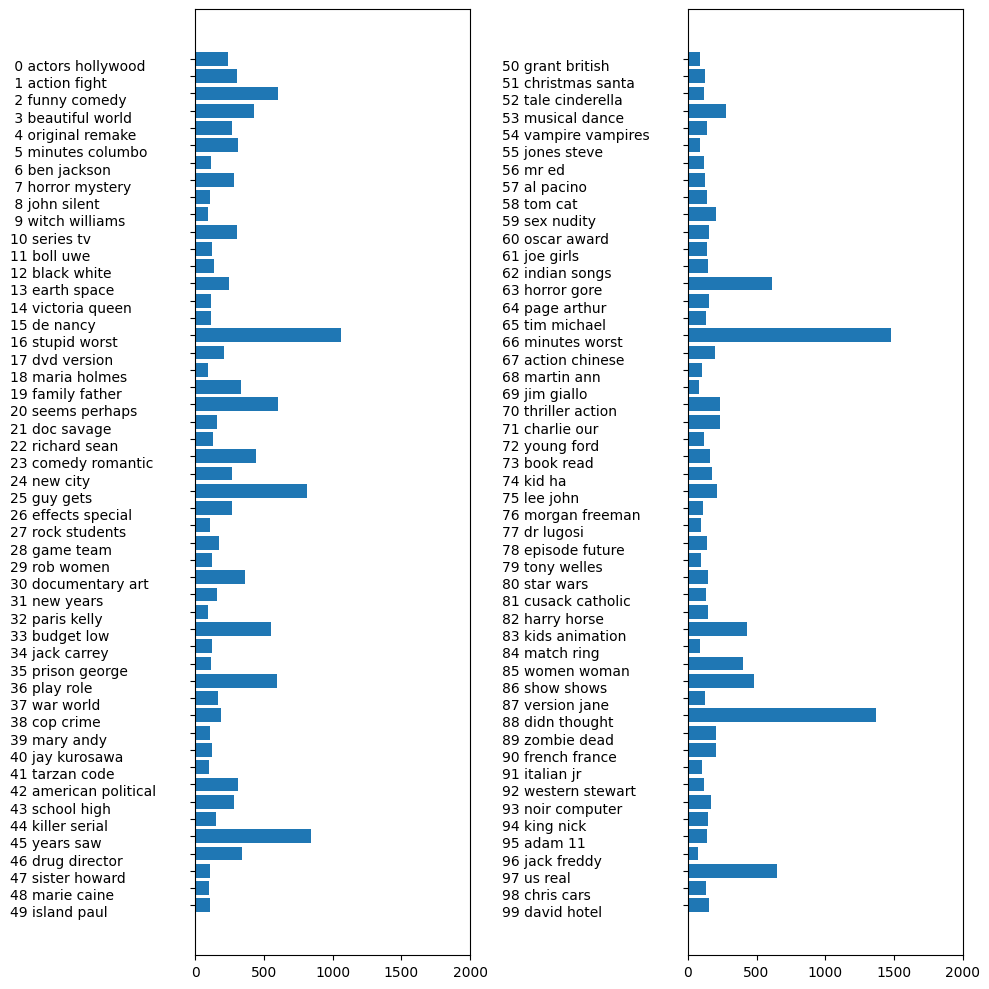

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
#两列的条形图:
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()


最重要的主题是主题97，它可能主要包含停用词，可能还有一些稍负面的单词;主题 16明显是有关负面评论的;然后是一些特定类型的主题与主题 36和37，这二者似乎都包含表示赞美的单词。

除了几个不太具体的主题之外，LDA 似乎主要发现了两种主题:特定类型的主题与特定评分的主题。这是一个有趣的发现，因为大部分评论都由一些与电影相关的评论与一些证明或强调评分的评论组成。

在没有标签的情况下(或者像本章的例子这样，即使有标签的情况下)，像 LDA 这样的主题模型是理解大型文本语料库的有趣方法。不过LDA算法是随机的，改变 random_state参数可能会得到完全不同的结果。虽然找到主题可能很有用，但对于从无监督模型中得出的任何结论都应该持保留态度，我们建议通过查看特定主题中的文档来验证你的直觉LDA.transform 方法生成的主题有时也可以用于监督学习的紧凑表示。当训练样例很少时这一方法特别有用。